# Визуализация результатов сегментации извержения вулкана с помощью нейронных сетей


# 1. Problem Statement
Визаулизация полученных результатов предсказания и сохранение истории наблюдения в структурированном виде с меньшим объемом занимаемого дискового пространства

### Libraries and Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Common libraries
import os
import random
from glob import glob
from imutils import paths
from os import path
import re
import imageio  
import math

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from skimage.feature import hog
from skimage import data, exposure

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
plt.rcParams["axes.grid"] = False

# Modeling Algorithms
import tensorflow as tf
from keras.utils import to_categorical
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

# Image segmantation
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table

print(tf.__version__)
print(tf.executing_eagerly())


2.4.1
True


In [ ]:
project_path = '/content/drive/MyDrive/ML/Volcano/'
IMG_SIZE = (256, 256)

IMG_HEIGHT = IMG_SIZE[0]
IMG_WIDTH = IMG_SIZE[1]

class_status = {0: 'alert', 
               1: 'normal'}

class_pillar = {0: '-', 
               1: 'pillar'}

class_lava = {0: '-', 
              1: 'lava'} 

mask_thrsh = 0.00001
center_thrsh = 0.7
small_obj = 5

In [ ]:
# Загрузка изображения и приведение к общему размеру 
def load_image(path, target_size=IMG_SIZE):
    image = cv2.imread(path)[...,::-1]
    image = cv2.resize(image, target_size)
    return image  

def load_image_io(path):
    # используем imageio, тк cv2 
    # не поддерживает загрузку .gif
    img = imageio.imread(path)
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def load_image_mask(path):
    # используем imageio, тк cv2 
    # не поддерживает загрузку .gif
    img = cv2.bitwise_not(imageio.imread(path))
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def binarise(img):
    thr, result = cv2.threshold(img, -1, 1, cv2.THRESH_OTSU)
    return result

# Обработка изображения - размерность не меняется
def gradient_image(src):
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    ##laplacian = cv2.Laplacian(image,cv2.CV_64F)
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)    
    image = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
    
    return image 

def gradient_image_gray(src):
    scale = 1
    delta = 0
    #ddepth = cv2.CV_16S
    ddepth = cv2.CV_32F
    src = cv2.GaussianBlur(src, (3, 3), 0)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)  
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    grad = cv2.cvtColor(grad, cv2.COLOR_GRAY2BGR)
    return grad

# Вычисляем угол и длину вектора градиента
def gradient_image_polar(src,ddepth = cv2.CV_32F, scale = 1, delta = 0 ):
    image = cv2.GaussianBlur(src, (3, 3), 0)
    grad_x = cv2.Sobel(image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    g, theta = cv2.cartToPolar(grad_x, grad_y)
    return g, theta

def create_mask(image, image_mask):    #  создаем маску, оставляем только нужный фрагмент, размер изображения не меняется, каналы убираются 
    init_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)  

    mask = np.zeros(image.shape[:2],np.uint8)
    mask[init_mask == 255] = 1
    mask[init_mask == 0] = 2 #Guess everything else is background

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    mask, bgdModel, fgdModel = cv2.grabCut(image,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    mask[mask == 1] = 255
    return mask

# Вывод заданного количества изображений из указанной папки
def show_images(imagePaths, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(imagePaths, 1):
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title('%s' % path.split('/')[-2])
      img = cv2.imread(path)[...,::-1]
      img = cv2.resize(img, IMG_SIZE)
      plt.imshow(img)


# Вывод заданного количества изображений для генератора
def show_images_gen(generator, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title(class_status.get(generator[1][i]))
      img = generator[0][i]
      plt.axis('off')
      plt.imshow(img)

# Вывод заданного количества изображений для генератора классов
def show_images_gen_class(generator, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      title = '%s: %s %s' % (class_status.get(generator[1][i]), class_pillar.get(generator[2][i]), class_lava.get(generator[3][i])) 
      subplot.set_title(title)
      img = generator[0][i]
      print('pillar lava clear cloud mist')
      print(generator[4][i])
      plt.axis('off')
      plt.imshow(img)

# Вывод заданного количества изображений для генератора классов  
def show_images_gen_binary_class(generator,  class_name='status', nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      title = ''
      if class_name == 'status': title = '%s' % (class_status.get(generator[1][i]))
      if class_name == 'pillar': title = '%s' % (class_pillar.get(generator[1][i])) 
      if class_name == 'lava':  title = '%s' % (class_lava.get(generator[1][i])) 
      subplot.set_title(title)
      img = generator[0][i]
      plt.axis('off')
      plt.imshow(img)

            

# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(20, 10))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        title = '%s: %s' % (class_status.get(int(round(score[0]))), np.round(score[0],3))
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        plt.axis('off')
  
def show_images_predict_mask(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols

    fig = plt.figure(figsize=(25, 25))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        covarage = np.round(np.sum(score)/ pow(256, 2) * 100 , 2) 
        #title = '%s: %s' % (class_status.get(int(round(score[0]))), np.round(score[0],3))
        title = 'cov %s ' % (covarage)
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8) 
        
        plt.imshow(load_image(path))
        #plt.imshow(score, cmap='gray', alpha=0.9)
        plt.imshow(score, cmap='Greens', alpha=0.5)


# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict_binary_class(test_files,y_pred, class_name='status', nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(20, 10))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        subplot = fig.add_subplot(nrows, ncols, i)
        title = ''
        if class_name == 'status': title = 'status: %s' % (np.round(score[0],3))
        if class_name == 'pillar': title = 'pillar: %s' % (np.round(score[0],3)) 
        if class_name == 'lava':  title = 'lava: %s' % (np.round(score[0],3)) 
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        plt.axis('off')
        
# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict_class(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(25, 25))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        title = 'pillar:%s lava:%s \nclear:%s cloud:%s mist:%s' % (np.round(score[0],3),np.round(score[1],3),  np.round(score[2],3), np.round(score[3],3), np.round(score[4],3))
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        plt.axis('off')

def plot_model_history(model_history):
      # Getting the accuracy and loss
      acc = model_history.history['accuracy']
      val_acc = model_history.history['val_accuracy']
      loss = model_history.history['loss']
      val_loss = model_history.history['val_loss']
      # Plotting the accuracy
      epochs = range(len(acc))

      fig = plt.figure(figsize=(16, 6))
      subplot = fig.add_subplot(1, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, '-o', label='Training accuracy')
      plt.plot(epochs, val_acc, '-', label='Validation accuracy')
      plt.title('Training and validation accuracy')
      plt.grid(linestyle='--')
      plt.legend()

      subplot = fig.add_subplot(1, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, '-o', label='Training Loss' )
      plt.plot(epochs, val_loss, '-', label='Validation Loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.grid(linestyle='--')
      plt.show()

def plot_model_history_dice(model_history):
      acc = model_history.history['binary_crossentropy']
      val_acc = model_history.history['dice_coef']
      loss = model_history.history['loss']
      epochs = range(len(acc))

      fig = plt.figure(figsize=(16, 6))
      subplot = fig.add_subplot(1, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, '-o', label='Training binary crossentropy')
      plt.plot(epochs, val_acc, '-', label='Training dice coef')
      plt.title('Binary crossentropy and dice coef')
      plt.grid(linestyle='--')
      plt.legend()

      subplot = fig.add_subplot(1, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, '-o', label='Training Loss' )
      plt.title('Training loss')
      plt.legend()
      plt.grid(linestyle='--')
      plt.show()


# функция-генератор загрузки тестовых изображений с диска  steps=len(imagePaths_test))
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

def test_img_generator(test_paths):   #  
    for path in test_paths:
        yield np.array([load_image(path)])
        

# функция используется в генераторах при загрузке изображений для определения класса для обучающей выборке по имени папки и файла
def encode(files_path):
    y_visible = []   # класс видимость категориальный признак (mist, cloud,clear)   
    y_pillar = []    # класс тип активности: 1 - парогазовый столб
    y_lava = []      # класс тип активности: 1 - лава
    y_activity = []  # обощенные признаки всех классов  - pillar	lava	visible__clear	visible__cloud	visible__mist
    for path in files_path:
              result_vis = re.match(r'[a-zA-Z]+', path.split(os.path.sep)[-1])  
              y_visible.append( result_vis.group(0))

              result = re.split(r'\+', path.split(os.path.sep)[-1])
              if result[1] == 'pillar': y_pillar.append(1) 
              else: y_pillar.append(0)
              if result[2] == 'lava': y_lava.append(1) 
              else: y_lava.append(0) 

              y_activity = pd.DataFrame()
              y_activity['pillar'] = y_pillar
              y_activity['lava'] = y_lava
              y_activity = y_activity.join(pd.get_dummies(y_visible, prefix='visible_'))
              y_activity = np.array(y_activity)
              
    return y_pillar, y_lava, y_activity

# функция-генератор загрузки обучающих данных с диска
def fit_generator_binary_class(files, class_name='status', batch_size=24):   
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y_status = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0    
                          for path in files[i:j]])

            y_pillar, y_lava, y_activity = encode(files[i:j])

            if class_name == 'status': y = y_status
            if class_name == 'pillar': y = np.array(y_pillar)
            if class_name == 'lava':   y = np.array(y_lava)

            yield (x, y)
  
# функция-генератор загрузки обучающих данных с диска
def fit_generator_classes(files, batch_size=24):   #  долго обучается 1 
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0    # y - основной класс 1 - normal, 0 - alert
                          for path in files[i:j]])

            y_pillar, y_lava, y_activity = encode(files[i:j])

            yield (x, np.array(y_activity))

# функция-генератор загрузки обучающих данных с диска для изображений (X) и масок (Y)
def fit_generator_mask(train_img_paths, train_mask_paths, batch_size=6):   
    batch_size = min(batch_size, len(train_img_paths))
    while True:
        #random.shuffle(train_img_paths,seed =42)
        for k in range(len(train_img_paths) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(train_img_paths):
                j = - j % len(train_img_paths)
            x = np.array([load_image(path) for path in train_img_paths[i:j]])

            y = np.array([binarise(load_image_mask(path)) for path in train_mask_paths[i:j]])
            # combine generators into one which yields image and masks
            train_generator = zip(x, y)   #проверить вместо x y
            yield (x, y)
            

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_ = tf.cast( tf.reshape(y_true, [-1]), tf.float32)
    y_pred_ = tf.cast( tf.reshape(y_pred, [-1]), tf.float32)
    y_true_f = K.flatten(y_true_)
    y_pred_f = K.flatten(y_pred_)
    intersection = K.sum(y_true_f * y_pred_f)
    return  (2. * intersection + smooth) /(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.2 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def show_mask_gradient(img, subplot):
  #mask = np.where((img<=0.00001),0,1).astype('uint8')    # обнуляем значения меньше заданного уровня, т.е очищаем картинку от малой вероятности принадлежности к классу "маска"
  

  #mask1 = np.where((img<=0.00001),0,1).astype('uint8')
  #mask1 = np.where((img<=0.0001),0,1).astype('uint8')
  #mask2 = cv2.bitwise_not(mask1) 
  #mask3 = binarise(mask1) 

  center = np.where((img>=0.8),1,0).astype('uint8') 
  #center_full = ndi.label(remove_small_objects(center, 5))[0]  # чтобы добавить в градиент надо максимальную площадь находить

  edges = canny(img)    
  fill_edge = ndi.binary_fill_holes(edges)
  edges_full = ndi.label(remove_small_objects(fill_edge, 5))[0]

  X,Y = np.meshgrid(np.arange(256), np.arange(256))

  array =np.array(center)
  dy, dx = np.gradient(center)

  n = 3
  plt.quiver(X[::n,::n],Y[::n,::n],-dx[::n,::n], -dy[::n,::n], 
           np.sqrt(dx[::n,::n]**2+dy[::n,::n]**2),
           units="xy", scale=0.08, cmap="Reds", alpha=0.5)
  
  plt.text(0, 12, np.round((np.sum(img)/ pow(256, 2)) * 100 , 3), fontsize=8)
  plt.text(230, 12, np.round(np.sum(center)/ np.sum(img) * 100 , 3), fontsize=8)

  plt.imshow(edges_full, cmap='Reds', alpha=0.5)
  
  #print(np.round((np.sum(img)/ pow(256, 2)) * 100 , 3) )  # площадь класса % картинки слева вверху
  #print(np.round(np.sum(center)/ np.sum(img) * 100 , 3) )   # площадь очага % маски справа вверху


def hog_image_plot(image, channel=False): # для маски False для исходного изображения True
  fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=channel)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  #ax1.axis('off')
  ax1.imshow(image, cmap=plt.cm.gray)
  ax1.set_title('Исходное изображение')

  # Rescale histogram for better display
  hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

  #ax2.axis('off')
  ax2.imshow(hog_image_rescaled, cmap='Blues')
  ax2.set_title('Histogram of Oriented Gradients')
  plt.show

# направление движения - центроиды маски и центроиды очага
# выделение контура вручную
def direction_from_mask(image):
    mask = np.where((image<=mask_thrsh),0,1).astype('uint8')    # обнуляем значения меньше заданного уровня, т.е очищаем картинку от малой вероятности принадлежности к классу "маска"
    center = np.where((image>=center_thrsh),1,0).astype('uint8')    # оставляем только самые яркие участки, преполагая что это эпицентр, очаг
    center_full = ndi.label(remove_small_objects(center, small_obj))[0]  # чтобы добавить в градиент надо максимальную площадь находить

    edges = canny(image)    # выделяем контур, потом соединяем маленькие контуры в общий
    fill_edge = ndi.binary_fill_holes(edges)
    edges_full = ndi.label(remove_small_objects(fill_edge, small_obj))[0]

    props_mask = {}
    props_center = {}

    r_a = []
    theta_a = []

    # центры контура и центр очага
    if np.max(mask) != 0:
        props_mask = regionprops_table(mask, properties=('area',
                                                    'centroid',
                                                    'orientation',
                                                    'major_axis_length',
                                                    'minor_axis_length'))
        mask_df = pd.DataFrame(props_mask)
        mask_df['x'] = props_mask['centroid-0']
        mask_df['y'] = props_mask['centroid-1']
        mask_df['radius'] = np.sqrt( mask_df['x'] * mask_df['x'] + mask_df['y'] * mask_df['y'] )   # переводим в полярные координаты
        mask_df['theta'] = 180 * (np.arctan(mask_df['y']/mask_df['x']))/np.pi  

        # координаты центроида самого большого участка для исходной маски
        x1 = mask_df[mask_df['area'] == mask_df['area'].max()] ['x']
        y1 = mask_df[mask_df['area'] == mask_df['area'].max()] ['y']
        r1 = mask_df[mask_df['area'] == mask_df['area'].max()] ['radius']
        t1 = mask_df[mask_df['area'] == mask_df['area'].max()] ['theta']
        
    if np.max(center_full) != 0:
        props_center = regionprops_table(center_full, properties=('area',
                                                    'centroid',
                                                    'orientation',
                                                    'major_axis_length',
                                                    'minor_axis_length'))
        center_df = pd.DataFrame(props_center)
        center_df['x'] = props_center['centroid-0']
        center_df['y'] = props_center['centroid-1']
        center_df['radius'] = np.sqrt( center_df['x'] * center_df['x'] + center_df['y'] * center_df['y'] )
        center_df['theta'] = 180 * (np.arctan(center_df['y']/center_df['x']))/np.pi

        # координаты центроида самого большого участка для очага
        x = center_df[center_df['area'] == center_df['area'].max()] ['x']
        y = center_df[center_df['area'] == center_df['area'].max()] ['y']
        r = center_df[center_df['area'] == center_df['area'].max()] ['radius']
        t = center_df[center_df['area'] == center_df['area'].max()] ['theta']
        r_a = center_df['radius']
        theta_a = center_df['theta']

    return r_a,theta_a
    
def plot_direction(image, degrees, radians, direction_ = 'N', color_ = 'r'):
  # для лавы направление N, цвет r
  # для шлейфа направление S, цвет b
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # image axes
    ax1.set_title('Направление движения', fontsize=8)
    ax1.imshow(image)

    #degrees, radians = direction_from_mask(image_mask)

    bin_size = 10
    a , b =np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

    ax2 = fig.add_subplot(111, projection='polar',facecolor="none")
    ax2.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0,  edgecolor='k', alpha = 0.6, color =  color_)
    ax2.set_theta_zero_location(direction_)
    ax2.set_theta_direction(-1)

    ax2.set_xticklabels('', color='w')
    ax2.set_yticklabels('', color='w')
    ax2.set_frame_on(False)

    #ax2.set_thetamin(230)  #сектор можно направить вниз для лавы и вверх для столба
    #ax2.set_thetamax(125)

def plot_direction_only(title, degrees, radians, direction_ = 'N', color_ = 'r'):
  # для лавы направление N, цвет r
  # для шлейфа направление S, цвет b
    fig = plt.figure()

    bin_size = 10
    a , b =np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

    ax2 = fig.add_subplot(111, projection='polar')
    ax2.set_title(title, fontsize=8)
    ax2.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.2,  edgecolor='k', alpha = 0.6, color =  color_)
    ax2.set_theta_zero_location(direction_)
    ax2.set_theta_direction(-1)

    ax2.set_yticklabels('', color='b')
    ax2.set_frame_on(True)


# 2. Data Understanding

Загружаем полученные на предыдущих шагах результаты предсказния моделей. Маасив данных имеет следующую структуру:

- filename : имя файла из тестовой выборки
- image : исходное изображение
- pred_ResNet_model_lava: вероятность наличия лавы по модели ResNet
- pred_ResNet_model_pillar: вероятность наличия шлейфа по модели ResNet
- pred_vgg_model_lava: вероятность наличия лавы по модели VGG
- pred_vgg_model_pillar: вероятность наличия шлейфа по модели VGG
- mask_lava: маска лавы для исходного изображения
- mask_pillar: маска шлейфа для исходного изображения


### 2.2 Вспомогательные функции

In [ ]:
IMG_SIZE = (256, 256)
class_status = {0: 'alert', 
               1: 'normal'}

class_pillar = {0: '-', 
               1: 'pillar'}

class_lava = {0: '-', 
              1: 'lava'}              
               
# Загрузка изображения и приведение к общему размеру 
def load_image(path, target_size=IMG_SIZE):
    image = cv2.imread(path)[...,::-1]
    image = cv2.resize(image, target_size)
    return image  

# Обработка изображения - размерность не меняется
def gradient_image(src):
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    ##laplacian = cv2.Laplacian(image,cv2.CV_64F)
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)    
    image = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
    
    return image 

# Вычисляем угол и длину вектора градиента
def gradient_image_polar(src,ddepth = cv2.CV_32F, scale = 1, delta = 0 ):
    image = cv2.GaussianBlur(src, (3, 3), 0)
    grad_x = cv2.Sobel(image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    g, theta = cv2.cartToPolar(grad_x, grad_y)
    return g, theta


# Вывод заданного количества изображений из указанной папки
def show_images(imagePaths, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(imagePaths, 1):
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title('%s' % path.split('/')[-2])
      img = cv2.imread(path)[...,::-1]
      img = cv2.resize(img, IMG_SIZE)
      plt.imshow(img)


# Вывод заданного количества изображений для генератора
def show_images_gen(generator, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title(class_status.get(generator[1][i]))
      img = generator[0][i]
      plt.imshow(img)

# Вывод заданного количества изображений для генератора классов
def show_images_gen_class(generator, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      title = '%s: %s %s' % (class_status.get(generator[1][i]), class_pillar.get(generator[2][i]), class_lava.get(generator[3][i])) 
      subplot.set_title(title)
      img = generator[0][i]
      print('pillar lava clear cloud mist')
      print(generator[4][i])
      plt.imshow(img)

# Вывод заданного количества изображений для генератора классов  
def show_images_gen_binary_class(generator,  class_name='status', nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      title = ''
      if class_name == 'status': title = '%s' % (class_status.get(generator[1][i]))
      if class_name == 'pillar': title = '%s' % (class_pillar.get(generator[1][i])) 
      if class_name == 'lava':  title = '%s' % (class_lava.get(generator[1][i])) 
      subplot.set_title(title)
      img = generator[0][i]
      plt.imshow(img)

            

# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(20, 10))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        title = '%s: %s' % (class_status.get(int(round(score[0]))), np.round(score[0],3))
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)


# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict_binary_class(test_files,y_pred, class_name='status', nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(20, 10))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        subplot = fig.add_subplot(nrows, ncols, i)
        title = ''
        if class_name == 'status': title = 'status: %s' % (np.round(score[0],3))
        if class_name == 'pillar': title = 'pillar: %s' % (np.round(score[0],3)) 
        if class_name == 'lava':  title = 'lava: %s' % (np.round(score[0],3)) 
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        
# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict_class(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(25, 25))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        title = 'pillar:%s lava:%s \nclear:%s cloud:%s mist:%s' % (np.round(score[0],3),np.round(score[1],3),  np.round(score[2],3), np.round(score[3],3), np.round(score[4],3))
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)

def plot_model_history(model_history):
      # Getting the accuracy and loss
      acc = model_history.history['accuracy']
      val_acc = model_history.history['val_accuracy']
      loss = model_history.history['loss']
      val_loss = model_history.history['val_loss']
      # Plotting the accuracy
      epochs = range(len(acc))

      fig = plt.figure(figsize=(16, 6))
      subplot = fig.add_subplot(1, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, 'bo', label='Training accuracy')
      plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
      plt.title('Training and validation accuracy')
      plt.legend()

      subplot = fig.add_subplot(1, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, 'bo', label='Training Loss')
      plt.plot(epochs, val_loss, 'b', label='Validation Loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=24):   #  можно удалить дублируется
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])



In [ ]:
def encode(files_path):
    y_visible = []   # y_visible -  класс видимость категориальный признак (mist, cloud,clear)   
    y_pillar = []    # класс тип активности: 1 - парогазовый столб
    y_lava = []      # класс тип активности: 1 - лава
    y_activity = []  # обощенные признаки всех классов  - pillar	lava	visible__clear	visible__cloud	visible__mist
    for path in files_path:
              result_vis = re.match(r'[a-zA-Z]+', path.split(os.path.sep)[-1])  
              y_visible.append( result_vis.group(0))

              result = re.split(r'\+', path.split(os.path.sep)[-1])
              if result[1] == 'pillar': y_pillar.append(1) 
              else: y_pillar.append(0)
              if result[2] == 'lava': y_lava.append(1) 
              else: y_lava.append(0) 

              y_activity = pd.DataFrame()
              y_activity['pillar'] = y_pillar
              y_activity['lava'] = y_lava
              #y_activity['visible'] = y_visible    
              y_activity = y_activity.join(pd.get_dummies(y_visible, prefix='visible_'))
              y_activity = np.array(y_activity)
              
    return y_pillar, y_lava, y_activity


# функция-генератор загрузки обучающих данных с диска
def fit_generator_binary_class(files, class_name='status', batch_size=24):   
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y_status = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0    # y - основной класс 1 - normal, 0 - alert
                          for path in files[i:j]])

            y_pillar, y_lava, y_activity = encode(files[i:j])

            if class_name == 'status': y = y_status
            if class_name == 'pillar': y = np.array(y_pillar)
            if class_name == 'lava':   y = np.array(y_lava)

            yield (x, y)
  
# функция-генератор загрузки обучающих данных с диска
def fit_generator_classes(files, batch_size=24):   #  долго обучается 1 
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0    # y - основной класс 1 - normal, 0 - alert
                          for path in files[i:j]])

            y_pillar, y_lava, y_activity = encode(files[i:j])

            yield (x, np.array(y_activity))


def show_mask_gradient(img, subplot):

  #mask = np.where((img<=0.00001),0,1).astype('uint8')    # обнуляем значения меньше заданного уровня, т.е очищаем картинку от малой вероятности принадлежности к классу "маска"
  

  #mask1 = np.where((img<=0.00001),0,1).astype('uint8')
  #mask1 = np.where((img<=0.0001),0,1).astype('uint8')
  #mask2 = cv2.bitwise_not(mask1) 
  #mask3 = binarise(mask1) 

  center = np.where((img>=0.8),1,0).astype('uint8') 
  #center_full = ndi.label(remove_small_objects(center, 5))[0]  # чтобы добавить в градиент надо максимальную площадь находить

  edges = canny(img)    
  fill_edge = ndi.binary_fill_holes(edges)
  edges_full = ndi.label(remove_small_objects(fill_edge, 5))[0]

  X,Y = np.meshgrid(np.arange(256), np.arange(256))

  array =np.array(center)
  dy, dx = np.gradient(center)

  n = 3
  plt.quiver(X[::n,::n],Y[::n,::n],-dx[::n,::n], -dy[::n,::n], 
           np.sqrt(dx[::n,::n]**2+dy[::n,::n]**2),
           units="xy", scale=0.08, cmap="Reds", alpha=0.5)
  
  plt.text(0, 10,np.round((np.sum(img)/ pow(256, 2)) * 100 , 3))
  plt.text(240, 10,np.round(np.sum(center)/ np.sum(img) * 100 , 3))

  plt.imshow(edges_full, cmap='Reds', alpha=0.5)

  #print(np.round((np.sum(img)/ pow(256, 2)) * 100 , 3) )  # площадь класса % картинки слева вверху
  #print(np.round(np.sum(center)/ np.sum(img) * 100 , 3) )   # площадь очага % маски справа вверху

### 2.1 Загрузка данных



In [ ]:
test_pred_df = pd.read_pickle(path.join(project_path,'data/processed/test_pred.pkl'))

In [ ]:
test_pred_df.shape

(45, 8)

In [ ]:
test_pred_df.head(1)

filename  ... pred_vgg_model_pillar
0  1102.jpg  ...              0.263951

[1 rows x 8 columns]

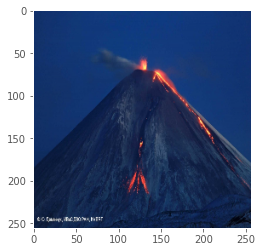

In [ ]:
image = test_pred_df['image'][6]
plt.imshow(image)

Predictions probabilities Resnet - VGG:
activity class
pillar -  0.174 -  0.264
lava   -  0.034 -  0.473

Predictions probability mask and
coverage pillar -  4.394 %
coverage lava  -  2.178 %


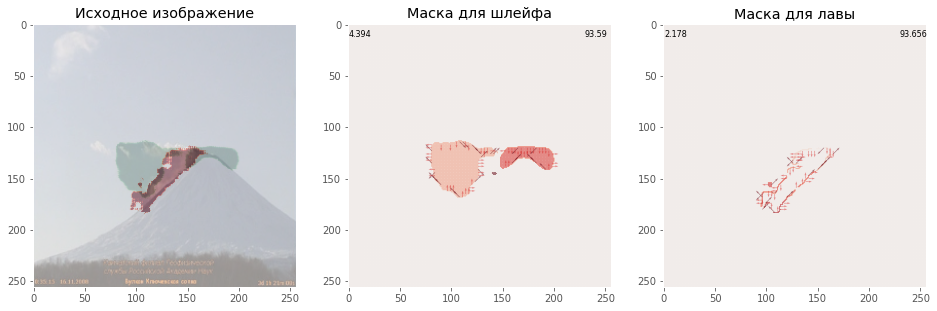

In [ ]:
n_images = 1

fig = plt.figure(figsize=(16, 8))
for i in range(n_images): 

  image = test_pred_df['image'][i]


  y_pred_resnet_pillar = test_pred_df['pred_ResNet_model_pillar'][i]
  y_pred_resnet_lava = test_pred_df['pred_ResNet_model_lava'][i]
  y_pred_vgg_pillar = test_pred_df['pred_vgg_model_pillar'][i]
  y_pred_vgg_lava = test_pred_df['pred_vgg_model_lava'][i]
  y_pred_pillar = test_pred_df['mask_pillar'][i] 
  y_pred_lava = test_pred_df['mask_lava'][i]


  subplot = fig.add_subplot(1, 3, 1)
  coverage_pillar = np.round(np.sum(y_pred_pillar)/ pow(256, 2) * 100 , 3) 
  coverage_lava = np.round(np.sum(y_pred_lava)/ pow(256, 2) * 100 , 3) 
  subplot.set_title('Исходное изображение')
  plt.imshow(image)

  print('Predictions probabilities Resnet - VGG:')
  print('activity class')
  print('pillar - ',np.round(y_pred_resnet_pillar,3),'- ',np.round(y_pred_vgg_pillar,3))
  print('lava   - ',np.round(y_pred_resnet_lava,3),'- ',np.round(y_pred_vgg_lava,3))

  plt.imshow(y_pred_pillar, cmap='Greens', alpha=0.3)
  plt.imshow(y_pred_lava, cmap='Reds', alpha=0.4)

  print('\nPredictions probability mask and')
  print('coverage pillar - ',coverage_pillar,'%')
  print('coverage lava  - ',coverage_lava,'%')

  subplot1 = fig.add_subplot(1, 3, 2)
  subplot1.set_title('Маска для шлейфа')
  show_mask_gradient(y_pred_pillar, subplot1)

  subplot2 = fig.add_subplot(1, 3, 3)
  subplot2.set_title('Маска для лавы')
  show_mask_gradient(y_pred_lava, subplot2)

  plt.show()

   # дополнительно выводится на картинке 
   # площадь класса % картинки слева вверху
   # площадь очага % маски справа вверху

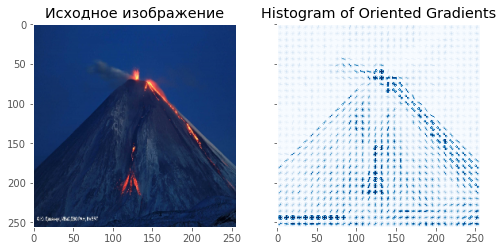

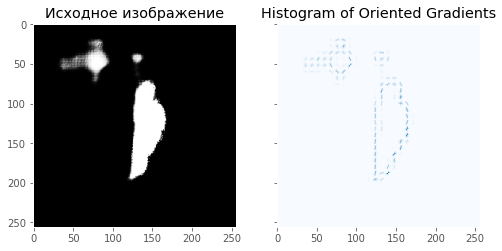

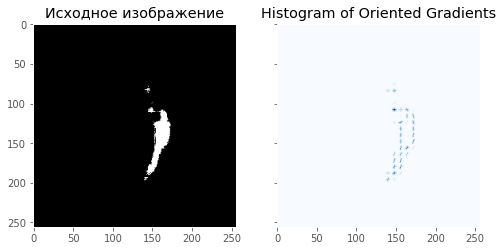

In [ ]:
hog_image_plot(image, channel=True )
hog_image_plot(y_pred_pillar, channel=False )
hog_image_plot(y_pred_lava, channel=False )


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.174 -  0.264
lava   -  0.034 -  0.473


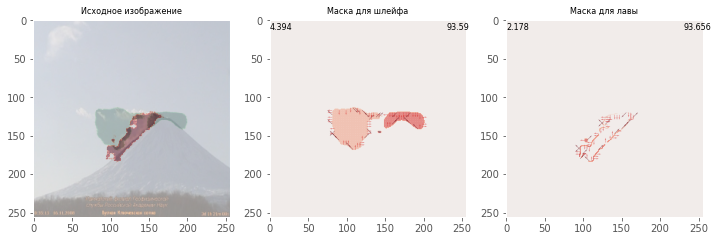


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.015 -  0.237
lava   -  0.999 -  0.835


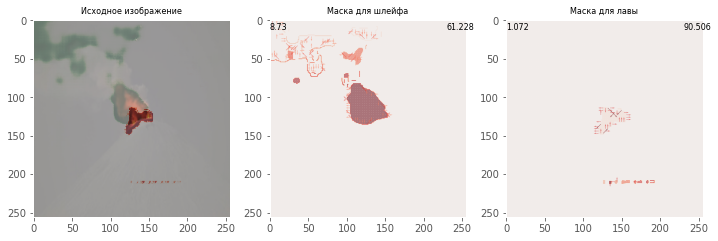


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.051 -  0.076
lava   -  0.024 -  0.56


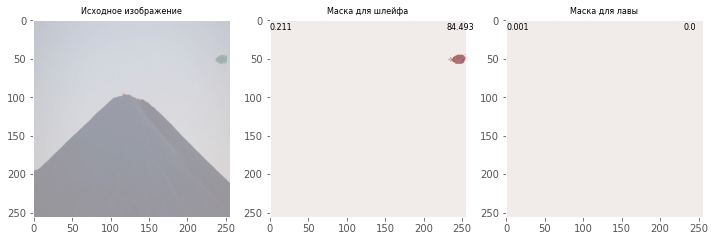


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.901 -  0.893
lava   -  0.017 -  0.522


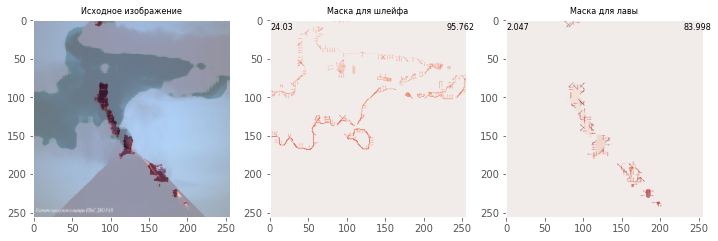


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.173 -  0.162
lava   -  0.999 -  0.915


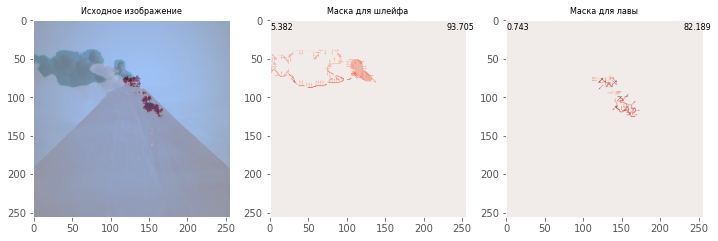

In [ ]:
n_images = 5

for i in range(n_images): 
  fig = plt.figure(figsize=(12, 10))
  image = test_pred_df['image'][i]

  y_pred_resnet_pillar = test_pred_df['pred_ResNet_model_pillar'][i]
  y_pred_resnet_lava = test_pred_df['pred_ResNet_model_lava'][i]
  y_pred_vgg_pillar = test_pred_df['pred_vgg_model_pillar'][i]
  y_pred_vgg_lava = test_pred_df['pred_vgg_model_lava'][i]
  y_pred_pillar = test_pred_df['mask_pillar'][i] 
  y_pred_lava = test_pred_df['mask_lava'][i]

  subplot = fig.add_subplot(1, 3, 1)
  coverage_pillar = np.round(np.sum(y_pred_pillar)/ pow(256, 2) * 100 , 3) 
  coverage_lava = np.round(np.sum(y_pred_lava)/ pow(256, 2) * 100 , 3) 
  
  subplot.set_title('Исходное изображение', fontsize=8) 
  plt.imshow(image)

  print('\nPredictions probabilities Resnet - VGG:')
  print('activity class')
  print('pillar - ',np.round(y_pred_resnet_pillar,3),'- ',np.round(y_pred_vgg_pillar,3))
  print('lava   - ',np.round(y_pred_resnet_lava,3),'- ',np.round(y_pred_vgg_lava,3))

  plt.imshow(y_pred_pillar, cmap='Greens', alpha=0.3)
  plt.imshow(y_pred_lava, cmap='Reds', alpha=0.4)

  subplot1 =  fig.add_subplot(1, 3, 2)
  subplot1.set_title('Маска для шлейфа', fontsize=8) 
  show_mask_gradient(y_pred_pillar, subplot1)

  subplot2 = fig.add_subplot(1, 3, 3)
  subplot2.set_title('Маска для лавы', fontsize=8) 
  show_mask_gradient(y_pred_lava, subplot2)

  plt.show()


# 3. Visualization

## 3.1 Анализ результатов

Для определения площади покрытия, напарвления изменения маски изображения проведем анализ контуров в полученных масках

In [ ]:
# выделение контура вручную

mask = np.where((y_pred_lava<=0.00001),0,1).astype('uint8')    # обнуляем значения меньше заданного уровня, т.е очищаем картинку от малой вероятности принадлежности к классу "маска"

print(np.round((np.sum(mask)/ pow(256, 2)) * 100 , 3) )  # площадь класса % картинки

center = np.where((y_pred_lava>=0.7),1,0).astype('uint8')    # оставляем только самые яркие участки, преполагая что это эпицентр, очаг
print(np.round(np.sum(center)/ np.sum(mask) * 100 , 3) )   # площадь очага % маски
center_full = ndi.label(remove_small_objects(center, 5))[0]  # чтобы добавить в градиент надо максимальную площадь находить

1.752
37.979


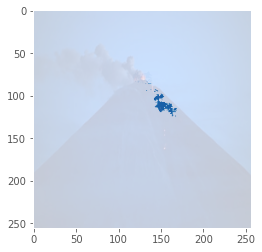

In [ ]:
plt.imshow(image, cmap='Blues')
plt.imshow(center_full, cmap='Blues', alpha = 0.8)

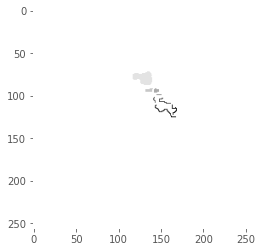

In [ ]:
edges = canny(y_pred_lava)    # выделяем контур, потом соединяем маленькие контуры в общий
fill_edge = ndi.binary_fill_holes(edges)

edges_full = ndi.label(remove_small_objects(fill_edge, 5))[0]

plt.imshow(cv2.bitwise_not(edges_full), cmap='gray')

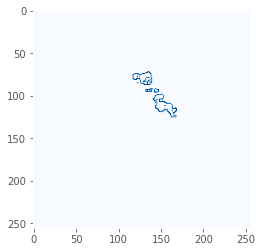

In [ ]:
plt.imshow(edges, cmap='Blues')

In [ ]:
np.max(center_full)>0  # проверка что есть контур

True

In [ ]:
# центры контура и центр очага

props_mask = regionprops_table(mask, properties=('area',
                                                 'centroid',
                                                 'orientation',
                                                 'major_axis_length',
                                                 'minor_axis_length'))

props_center = regionprops_table(center_full, properties=('area',
                                                 'centroid',
                                                 'orientation',
                                                 'major_axis_length',
                                                 'minor_axis_length'))

In [ ]:
mask_df = pd.DataFrame(props_mask)
center_df = pd.DataFrame(props_center)

In [ ]:
mask_df['x'] = props_mask['centroid-0']
mask_df['y'] = props_mask['centroid-1']
mask_df['radius'] = np.sqrt( mask_df['x'] * mask_df['x'] + mask_df['y'] * mask_df['y'] )   # переводим в полярные координаты
mask_df['theta'] = 180 * (np.arctan(mask_df['y']/mask_df['x']))/np.pi
mask_df

area  centroid-0  centroid-1  orientation  ...    x    y      radius     theta
0  1148         102         146     0.732148  ...  102  146  178.101095  55.06069

[1 rows x 10 columns]

In [ ]:
center_df['x'] = props_center['centroid-0']
center_df['y'] = props_center['centroid-1']
center_df['radius'] = np.sqrt( center_df['x'] * center_df['x'] + center_df['y'] * center_df['y'] )
center_df['theta'] = 180 * (np.arctan(center_df['y']/center_df['x']))/np.pi
center_df

area  centroid-0  centroid-1  orientation  ...    x    y      radius      theta
0    159          78         128     1.539305  ...   78  128  149.893295  58.642915
1      1          81         136     0.785398  ...   81  136  158.294030  59.222470
2      1          82         135     0.785398  ...   82  135  157.952525  58.725195
3      1          83         120     0.785398  ...   83  120  145.907505  55.329682
4      1          83         124     0.785398  ...   83  124  149.214611  56.203435
5      1          83         133     0.785398  ...   83  133  156.773722  58.033356
6      1          84         123     0.785398  ...   84  123  148.946299  55.669783
7      1          84         134     0.785398  ...   84  134  158.151826  57.917813
8      1          86         132     0.785398  ...   86  132  157.543645  56.915147
9      4          86         136     1.570796  ...   86  136  160.909913  57.692666
10     1          93         138     0.785398  ...   93  138  166.412139  56.023456
11     6          93         144     1.060591  ...   93  144  171.420536  57.144278
12     1          94         133     0.785398  ...   94  133  162.864975  54.748594
13     2          95         142     1.570796  ...   95  142  170.847886  56.216920
14   250         111         153     0.880517  ...  111  153  189.023808  54.039483
15     1         105         151     0.785398  ...  105  151  183.918460  55.186630
16     1         108         144     0.785398  ...  108  144  180.000000  53.130102
17     1         109         158     0.785398  ...  109  158  191.950514  55.399238
18     1         117         157     0.785398  ...  117  157  195.800919  53.305676
19     1         124         167     0.785398  ...  124  167  208.002404  53.405561

[20 rows x 10 columns]

In [ ]:
x = center_df[center_df['area'] == center_df['area'].max()] ['x']
y = center_df[center_df['area'] == center_df['area'].max()] ['y']
r = center_df[center_df['area'] == center_df['area'].max()] ['radius']
t = center_df[center_df['area'] == center_df['area'].max()] ['theta']

x1 = mask_df[mask_df['area'] == mask_df['area'].max()] ['x']
y1 = mask_df[mask_df['area'] == mask_df['area'].max()] ['y']
r1 = mask_df[mask_df['area'] == mask_df['area'].max()] ['radius']
t1 = mask_df[mask_df['area'] == mask_df['area'].max()] ['theta']

0    102
Name: x, dtype: int64 0    146
Name: y, dtype: int64


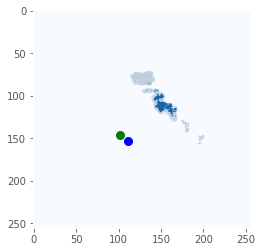

In [ ]:
plt.imshow(mask, cmap='Blues')
plt.imshow(center_full, cmap='Blues', alpha = 0.8)

plt.plot(x,y, 'bo',  markersize=8)
plt.plot(x1,y1, 'go',  markersize=8)
print(x1,y1)

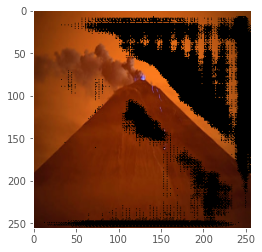

In [ ]:
#ii = image[:,:,2] - y_pred_lava
mask2 = np.where((y_pred_lava==0)|(y_pred_lava==2), 0, 1).astype('uint8')
result = image * mask2[:,:,np.newaxis]
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#ii =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
ii = image - result

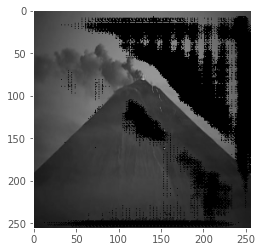

In [ ]:
#ii = image[:,:,2] - y_pred_lava
mask2 = np.where((y_pred_lava==0)|(y_pred_lava==2), 0, 1).astype('uint8')
result = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  * mask2[:,:]
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ii =  result  - cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


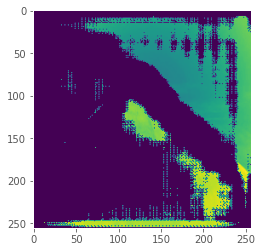

In [ ]:
plt.imshow(ii)

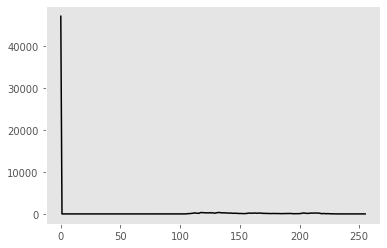

In [ ]:
histogram = cv2.calcHist([ii], [0], None, [256], [0, 256])    # маска применена в ручную
plt.plot(histogram, color='k')
plt.show()

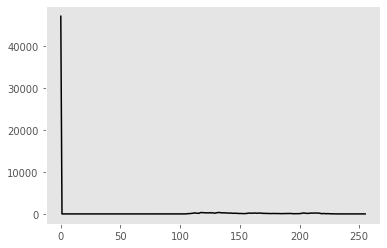

In [ ]:

histogram2 = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)], [0], result, [256], [0, 256])      
plt.plot(histogram, color='k')
plt.show()

In [ ]:
len(histogram)

256

## 3.2 Направление движения

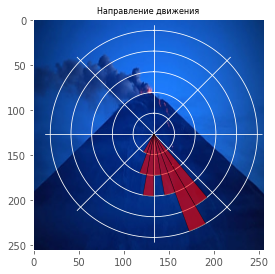

In [ ]:
degrees, radians = direction_from_mask(y_pred_lava)
plot_direction(image, degrees, radians, 'N', 'r')


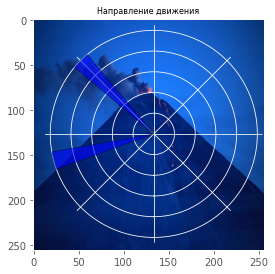

In [ ]:
degrees, radians =  direction_from_mask(y_pred_pillar)
plot_direction(image, degrees, radians, 'S', 'b')

In [ ]:
degrees

0     77.466122
1    132.969921
Name: radius, dtype: float64

## 3.3 Сохранение истории наблюдений

In [ ]:
result_pred_df = pd.DataFrame()
for i in range(len(test_pred_df)): 
  
  
  degrees_lava, radians_lava = [],[]
  degrees_pillar, radians_pillar = [],[]
  y_pred_resnet_pillar = test_pred_df['pred_ResNet_model_pillar'][i]
  y_pred_resnet_lava = test_pred_df['pred_ResNet_model_lava'][i]
  y_pred_vgg_pillar = test_pred_df['pred_vgg_model_pillar'][i]
  y_pred_vgg_lava = test_pred_df['pred_vgg_model_lava'][i]

  if (y_pred_vgg_lava >0.3 and  y_pred_resnet_lava > 0.3):
      degrees_lava, radians_lava = direction_from_mask(test_pred_df['mask_lava'][i])
  if (y_pred_vgg_pillar >0.3 and  y_pred_resnet_pillar > 0.3):
      degrees_pillar, radians_pillar = direction_from_mask(test_pred_df['mask_pillar'][i] )
    
  if ((y_pred_vgg_pillar >0.3 and  y_pred_resnet_pillar > 0.3) or (y_pred_vgg_lava >0.3 and  y_pred_resnet_lava > 0.3) ):
      result_pred_df = result_pred_df.append(
                              {'filename' : test_pred_df['filename'][i],
                              'image' : test_pred_df['image'][i],
                              'lava' : (y_pred_vgg_lava >0.3 and  y_pred_resnet_lava > 0.3),
                              'pillar' : (y_pred_vgg_pillar >0.3 and  y_pred_resnet_pillar > 0.3),
                              'pred_ResNet_model_lava' : test_pred_df['pred_ResNet_model_lava'][i],
                              'pred_ResNet_model_pillar' : test_pred_df['pred_ResNet_model_pillar'][i],
                              'pred_vgg_model_lava' : test_pred_df['pred_vgg_model_lava'][i],
                              'pred_vgg_model_pillar' : test_pred_df['pred_vgg_model_pillar'][i],
                              'mask_lava' : test_pred_df['mask_lava'][i] ,
                              'mask_pillar' : test_pred_df['mask_pillar'][i],
                              'degrees_lava': np.array(degrees_lava),
                              'radians_lava' : np.array(radians_lava),
                              'degrees_pillar': np.array(degrees_pillar),
                              'radians_pillar' : np.array(radians_pillar),
                               } ,  ignore_index=True)

In [ ]:
print('Всего сохранено изображений: ', len(result_pred_df))
result_pred_df['degrees_pillar']

Всего сохранено изображений:  19


0                                                    []
1     [83.0, 95.0, 84.02380615040002, 90.02221947941...
2                                                    []
3     [89.35882720806042, 12.165525060596439, 14.142...
4                                                    []
5     [159.2388143638353, 164.14932226482082, 165.91...
6     [92.45539465060976, 34.20526275297414, 22.0227...
7              [238.79907872519107, 238.40302011509837]
8              [239.35329536064467, 240.50363822611914]
9     [244.59149617270018, 230.8462691922917, 246.86...
10              [104.4030650891055, 238.92467432226417]
11    [236.31546711969574, 238.04621400055913, 238.7...
12                                                   []
13    [70.21395872616783, 68.00735254367721, 71.1688...
14                                                   []
15                                                   []
16                                                   []
17                                  [235.8495283

In [ ]:
result_pred_df[['filename', 'lava','pillar']]

filename  lava  pillar
0                               1142.jpg   1.0     0.0
1                               1147.jpg   0.0     1.0
2                               1149.jpg   1.0     0.0
3                               1150.jpg   0.0     1.0
4                               1829.jpg   1.0     0.0
5                               1837.jpg   0.0     1.0
6                               1839.jpg   1.0     1.0
7   2021-04-02-22-10-22-latest_Klyu2.jpg   0.0     1.0
8   2021-04-02-22-11-34-latest_Klyu2.jpg   0.0     1.0
9   2021-04-10-20-49-48-latest_Klyu2.jpg   0.0     1.0
10  2021-04-10-21-23-08-latest_Klyu2.jpg   0.0     1.0
11  2021-04-11-09-59-24-latest_Klyu2.jpg   0.0     1.0
12                          IMG_1991.jpg   1.0     0.0
13                          IMG_1992.jpg   1.0     1.0
14        Screenshot_20210418_100241.jpg   1.0     0.0
15        Screenshot_20210418_100303.jpg   1.0     0.0
16        Screenshot_20210418_100320.jpg   1.0     0.0
17                               img.jpg   0.0     1.0
18                              img2.jpg   1.0     1.0

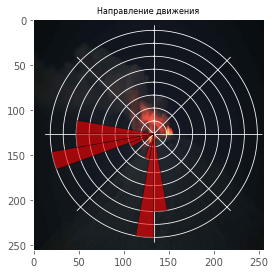

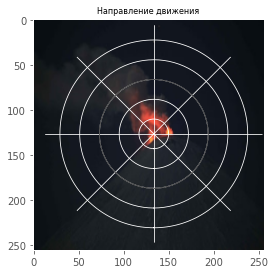

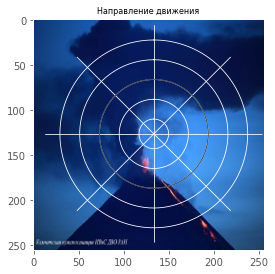

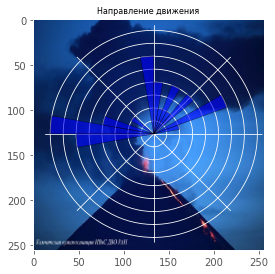

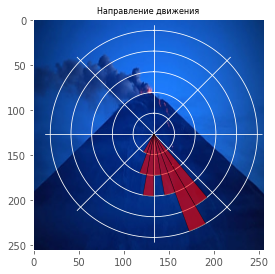

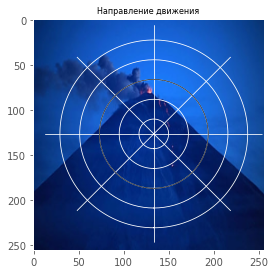

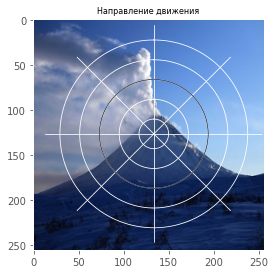

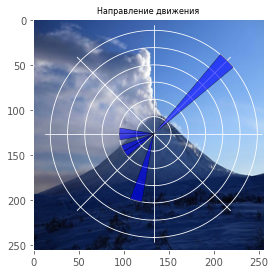

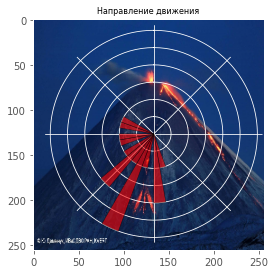

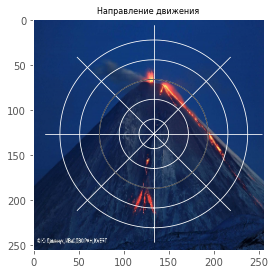

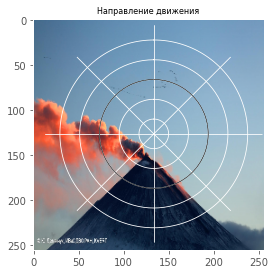

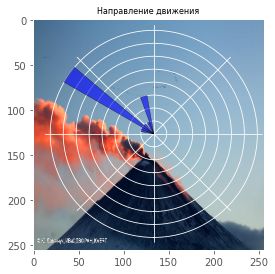

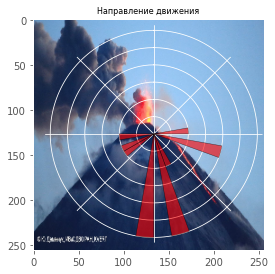

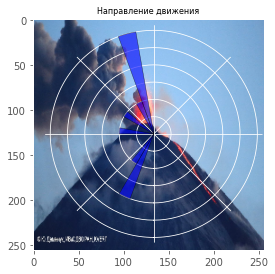

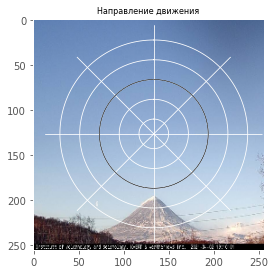

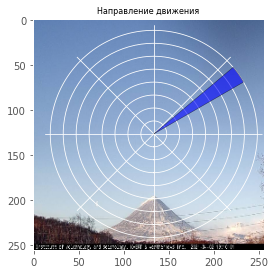

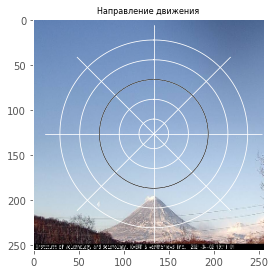

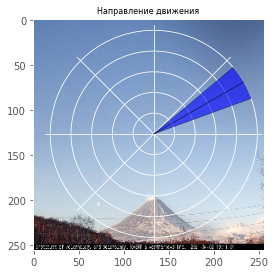

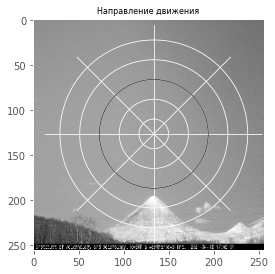

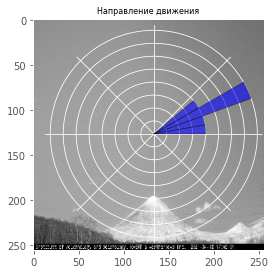

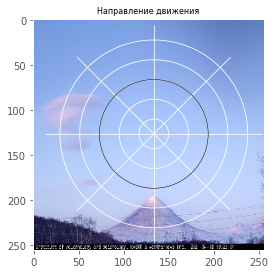

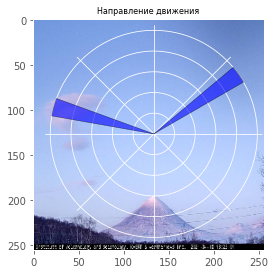

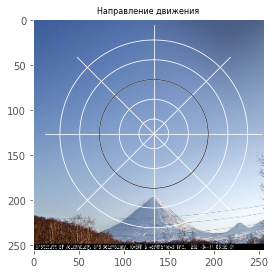

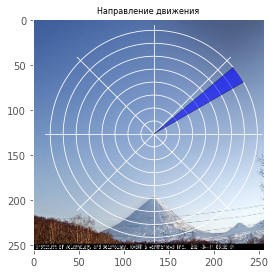

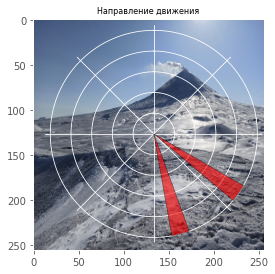

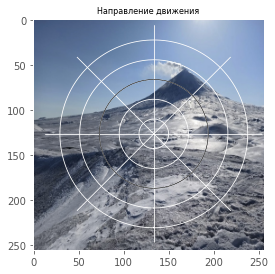

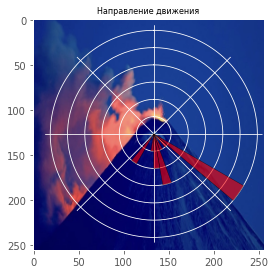

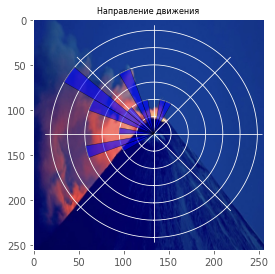

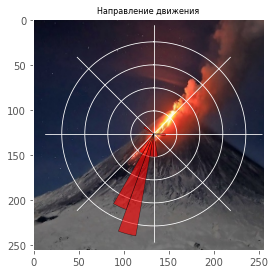

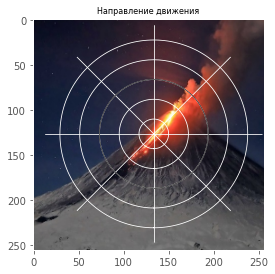

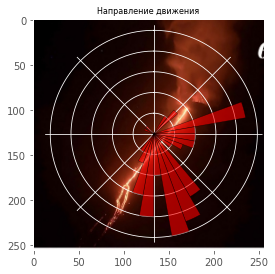

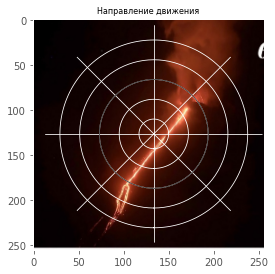

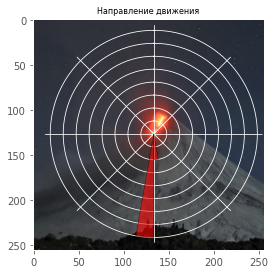

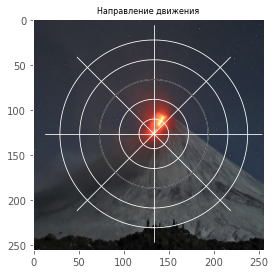

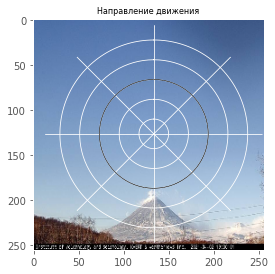

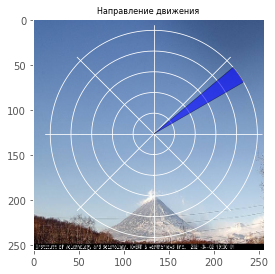

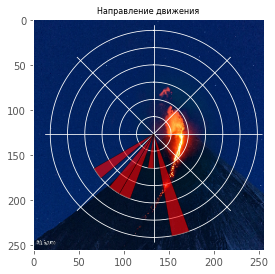

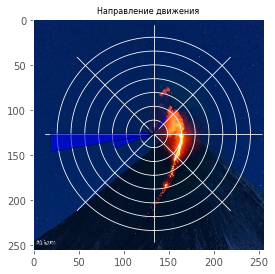

In [ ]:
n_images = len(result_pred_df)

for i in range(n_images): 
  image = result_pred_df['image'][i]

  y_pred_resnet_pillar = result_pred_df['pred_ResNet_model_pillar'][i]
  y_pred_resnet_lava = result_pred_df['pred_ResNet_model_lava'][i]
  y_pred_vgg_pillar = result_pred_df['pred_vgg_model_pillar'][i]
  y_pred_vgg_lava = result_pred_df['pred_vgg_model_lava'][i]
  y_pred_pillar = result_pred_df['mask_pillar'][i] 
  y_pred_lava = result_pred_df['mask_lava'][i]

  degrees_lava = result_pred_df['degrees_lava'][i]
  radians_lava = result_pred_df['radians_lava'][i]     
  degrees_pillar = result_pred_df['degrees_pillar'][i]
  radians_pillar = result_pred_df['radians_pillar'][i]     
 
  plot_direction(image, degrees_lava, radians_lava, 'N', 'r')
  plot_direction(image, degrees_pillar, radians_pillar, 'S', 'b')

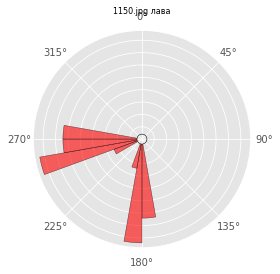

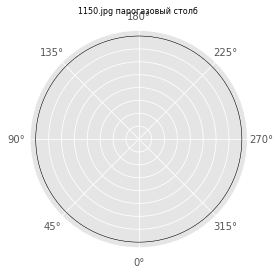

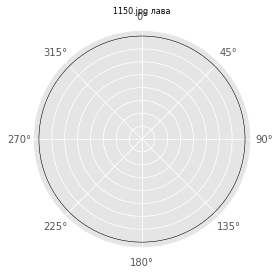

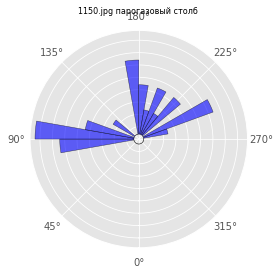

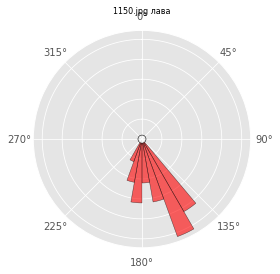

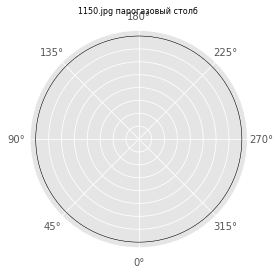

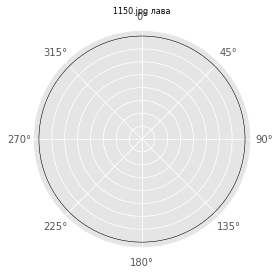

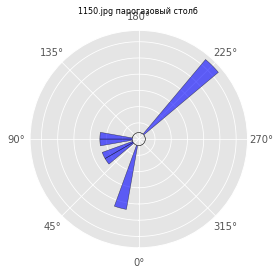

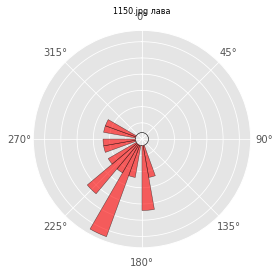

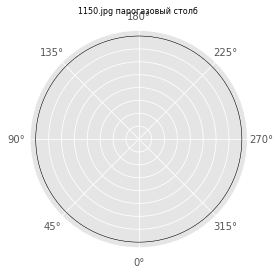

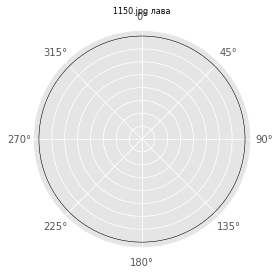

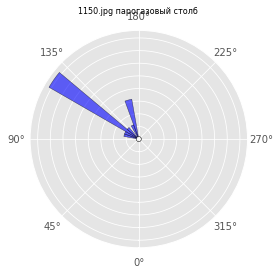

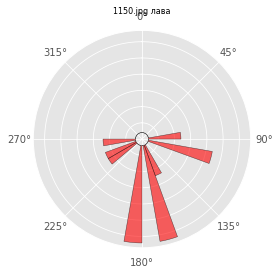

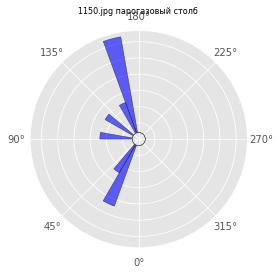

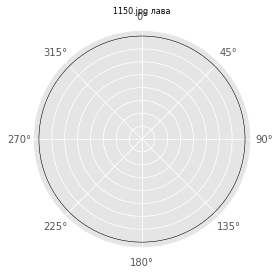

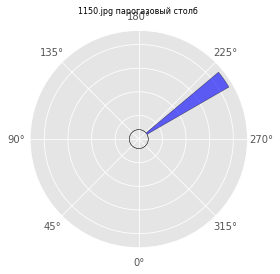

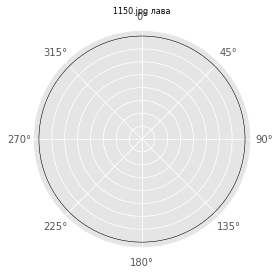

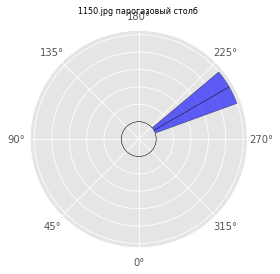

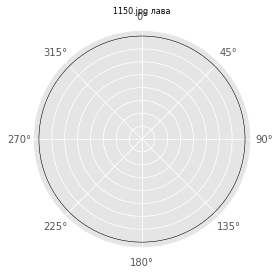

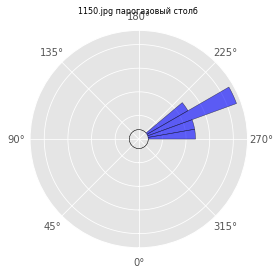

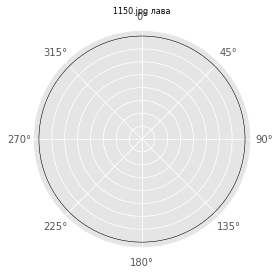

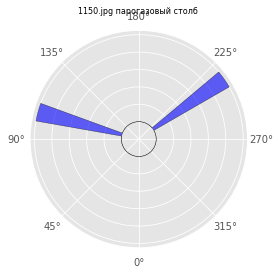

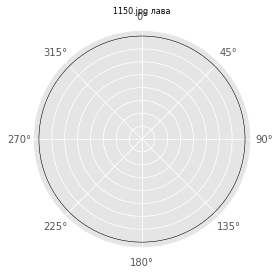

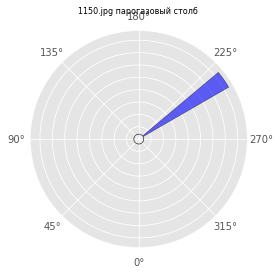

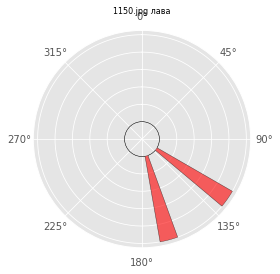

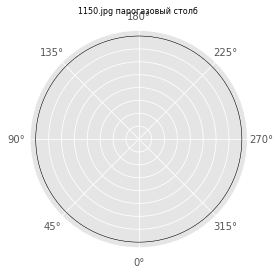

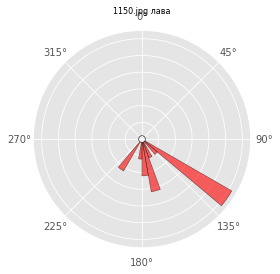

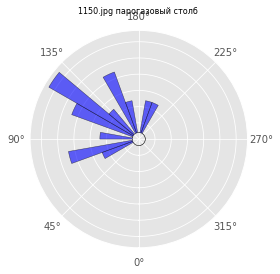

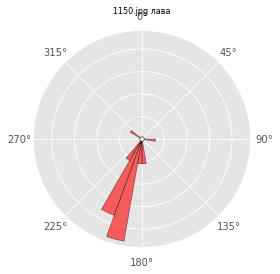

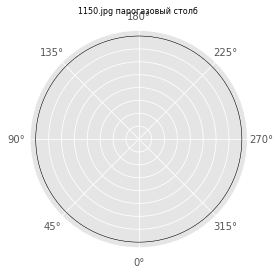

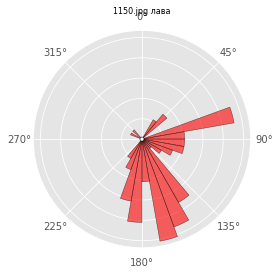

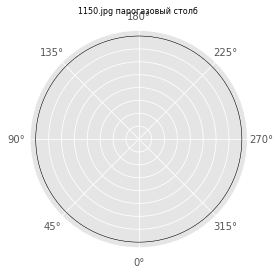

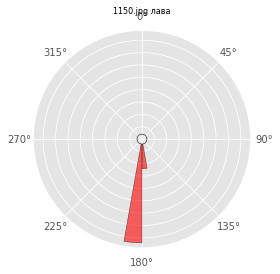

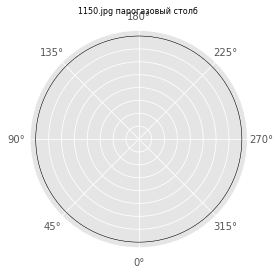

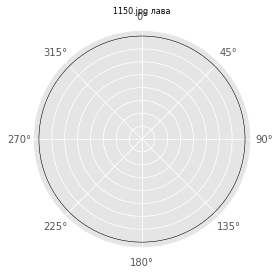

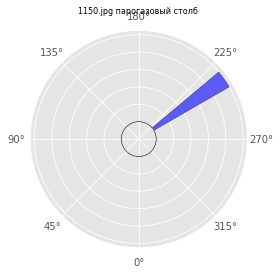

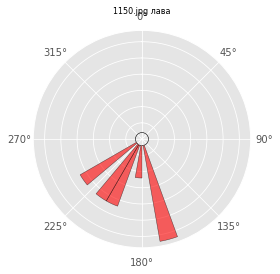

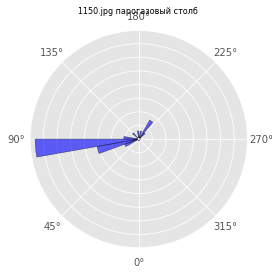

In [ ]:
n_images = len(result_pred_df)

for i in range(n_images): 
  image = result_pred_df['image'][i]

  y_pred_resnet_pillar = result_pred_df['pred_ResNet_model_pillar'][i]
  y_pred_resnet_lava = result_pred_df['pred_ResNet_model_lava'][i]
  y_pred_vgg_pillar = result_pred_df['pred_vgg_model_pillar'][i]
  y_pred_vgg_lava = result_pred_df['pred_vgg_model_lava'][i]
  y_pred_pillar = result_pred_df['mask_pillar'][i] 
  y_pred_lava = result_pred_df['mask_lava'][i]

  degrees_lava = result_pred_df['degrees_lava'][i]
  radians_lava = result_pred_df['radians_lava'][i]     
  degrees_pillar = result_pred_df['degrees_pillar'][i]
  radians_pillar = result_pred_df['radians_pillar'][i]     
 
  plot_direction_only(result_pred_df['filename'][3]+' лава', degrees_lava, radians_lava, 'N', 'r')
  plot_direction_only(result_pred_df['filename'][3]+' парогазовый столб ', degrees_pillar, radians_pillar, 'S', 'b')
  


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.015 -  0.237
lava   -  0.999 -  0.835
top left - total coverage %, top right - focus coverage %


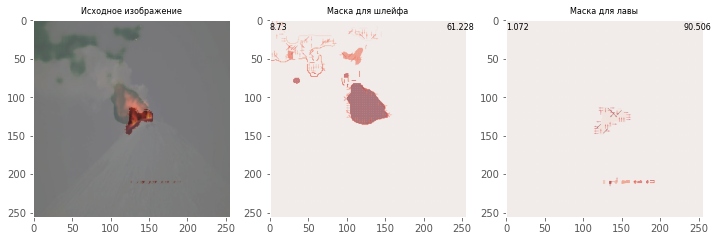


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.901 -  0.893
lava   -  0.017 -  0.522
top left - total coverage %, top right - focus coverage %


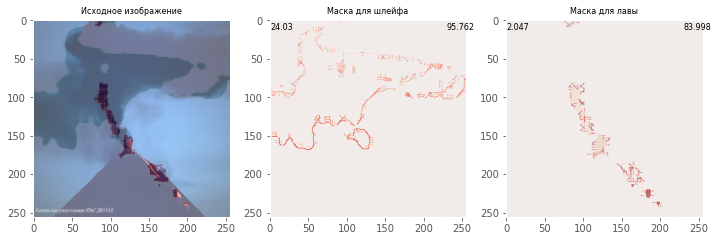


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.173 -  0.162
lava   -  0.999 -  0.915
top left - total coverage %, top right - focus coverage %


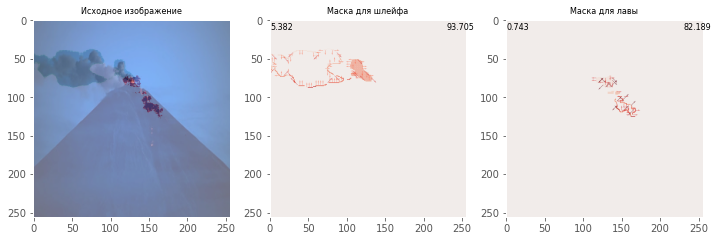


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.977 -  0.817
lava   -  0.243 -  0.974
top left - total coverage %, top right - focus coverage %


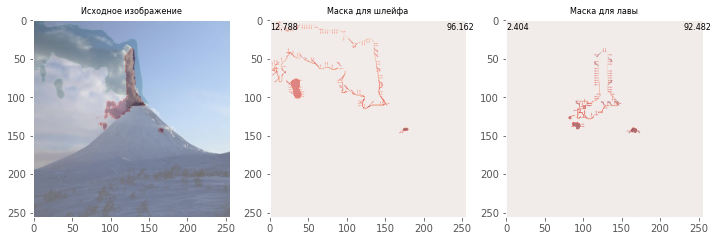


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.337 -  0.081
lava   -  0.981 -  1.0
top left - total coverage %, top right - focus coverage %


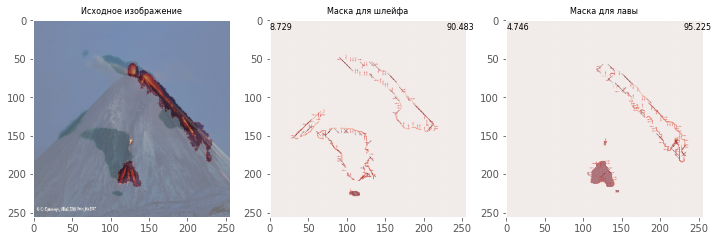


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.964 -  0.97
lava   -  0.145 -  0.51
top left - total coverage %, top right - focus coverage %


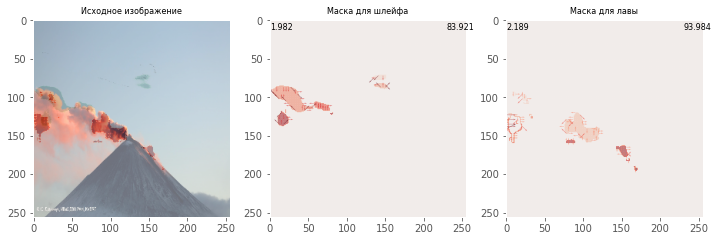


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.875 -  0.468
lava   -  0.945 -  0.973
top left - total coverage %, top right - focus coverage %


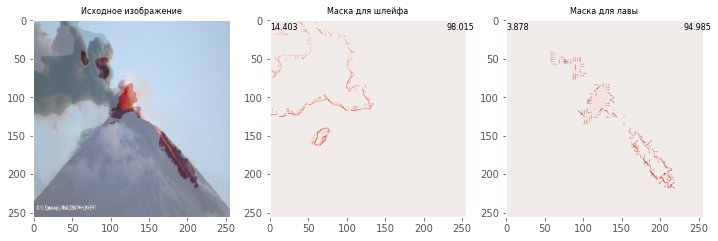


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.994 -  0.968
lava   -  0.003 -  0.011
top left - total coverage %, top right - focus coverage %


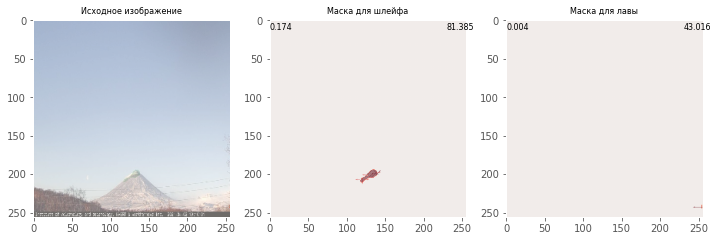


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.995 -  0.977
lava   -  0.003 -  0.01
top left - total coverage %, top right - focus coverage %


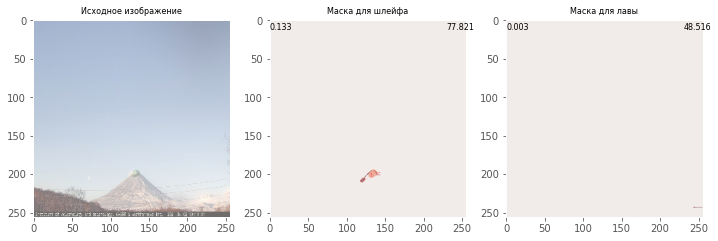


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.892 -  0.461
lava   -  0.004 -  0.009
top left - total coverage %, top right - focus coverage %


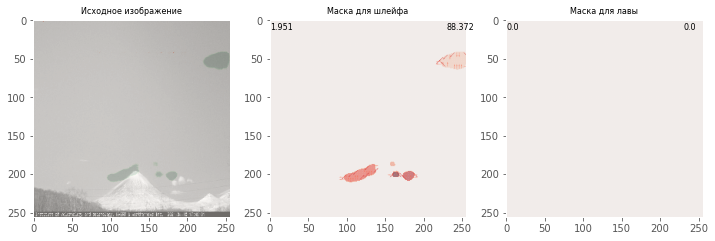


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.639 -  0.371
lava   -  0.003 -  0.018
top left - total coverage %, top right - focus coverage %


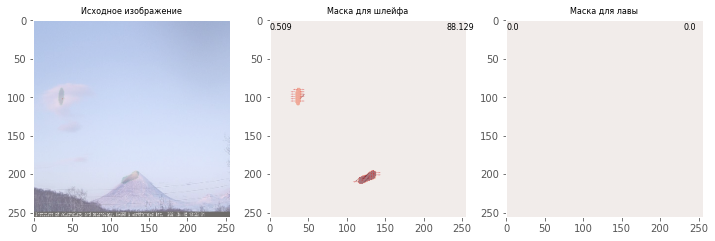


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.985 -  0.437
lava   -  0.004 -  0.009
top left - total coverage %, top right - focus coverage %


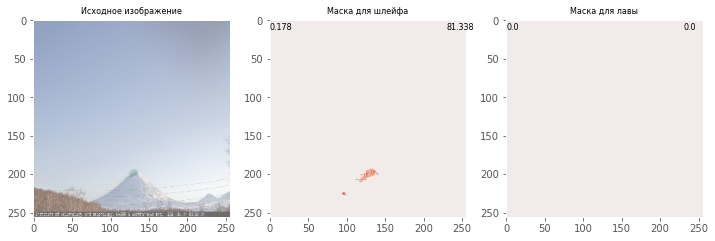


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.27 -  0.03
lava   -  0.606 -  0.969
top left - total coverage %, top right - focus coverage %


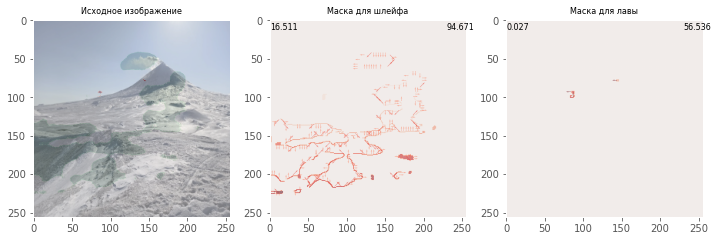


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.696 -  0.927
lava   -  0.994 -  0.998
top left - total coverage %, top right - focus coverage %


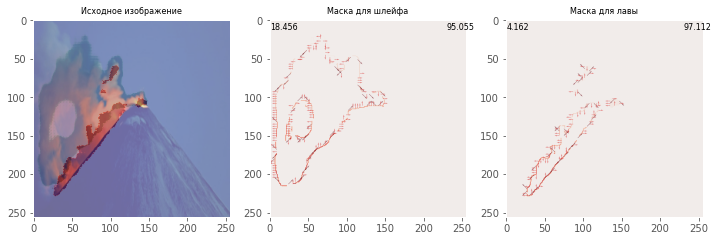


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.093 -  0.207
lava   -  0.998 -  0.995
top left - total coverage %, top right - focus coverage %


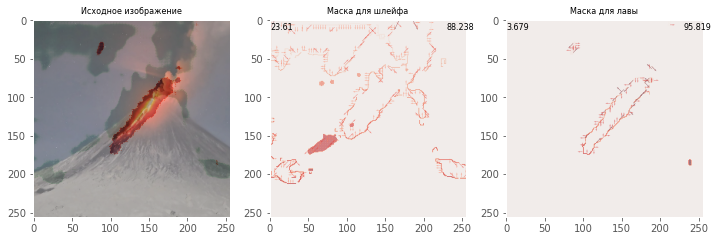


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.006 -  0.629
lava   -  0.995 -  0.941
top left - total coverage %, top right - focus coverage %


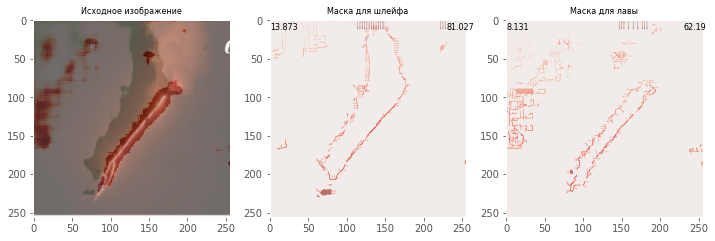


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.059 -  0.159
lava   -  0.94 -  0.878
top left - total coverage %, top right - focus coverage %


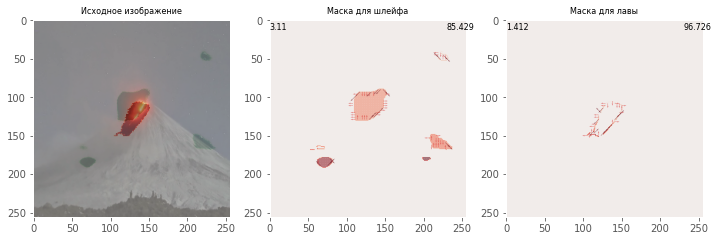


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.999 -  0.992
lava   -  0.003 -  0.01
top left - total coverage %, top right - focus coverage %


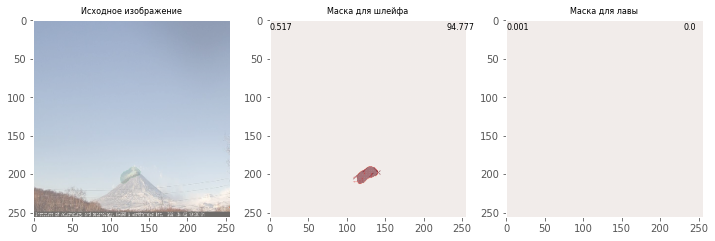


Predictions probabilities Resnet - VGG:
activity class
pillar -  0.734 -  0.514
lava   -  0.994 -  0.995
top left - total coverage %, top right - focus coverage %


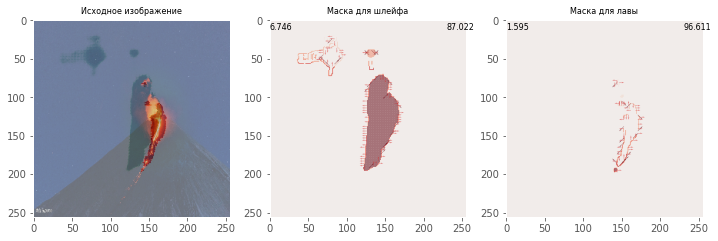

In [ ]:
n_images = len(result_pred_df)

for i in range(n_images): 
  fig = plt.figure(figsize=(12, 10))
  image = result_pred_df['image'][i]

  y_pred_resnet_pillar = result_pred_df['pred_ResNet_model_pillar'][i]
  y_pred_resnet_lava = result_pred_df['pred_ResNet_model_lava'][i]
  y_pred_vgg_pillar = result_pred_df['pred_vgg_model_pillar'][i]
  y_pred_vgg_lava = result_pred_df['pred_vgg_model_lava'][i]
  y_pred_pillar = result_pred_df['mask_pillar'][i] 
  y_pred_lava = result_pred_df['mask_lava'][i]

  subplot = fig.add_subplot(1, 3, 1)
  coverage_pillar = np.round(np.sum(y_pred_pillar)/ pow(256, 2) * 100 , 3) 
  coverage_lava = np.round(np.sum(y_pred_lava)/ pow(256, 2) * 100 , 3) 
  
  subplot.set_title('Исходное изображение', fontsize=8) 
  plt.imshow(image)

  print('\nPredictions probabilities Resnet - VGG:')
  print('activity class')
  print('pillar - ',np.round(y_pred_resnet_pillar,3),'- ',np.round(y_pred_vgg_pillar,3))
  print('lava   - ',np.round(y_pred_resnet_lava,3),'- ',np.round(y_pred_vgg_lava,3))
  print('top left - total coverage %, top right - focus coverage %')
  plt.imshow(y_pred_pillar, cmap='Greens', alpha=0.2)
  plt.imshow(y_pred_lava, cmap='Reds', alpha=0.3)

  subplot1 =  fig.add_subplot(1, 3, 2)
  subplot1.set_title('Маска для шлейфа', fontsize=8) 
  show_mask_gradient(y_pred_pillar, subplot1)

  subplot2 = fig.add_subplot(1, 3, 3)
  subplot2.set_title('Маска для лавы', fontsize=8) 
  show_mask_gradient(y_pred_lava, subplot2)

  plt.show()

# Appendix 1. Примеры радиальных диаграмм

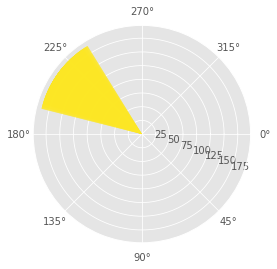

In [ ]:

# Compute pie slices
N = 20
theta = t
radii = r
width = np.pi / 4 * np.random.rand(N)
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)
ax.set_theta_direction(-1)
#plt.imshow(image)
plt.show()

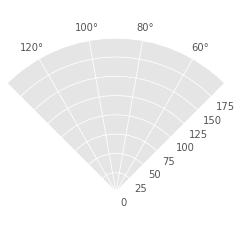

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
area =  radii**2
c = ax.scatter(t, r, c=colors,  cmap='hsv', alpha=0.75)

ax.set_thetamin(45)  #сектор
ax.set_thetamax(135)

plt.show()

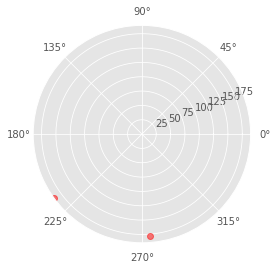

In [ ]:
r_a = [r,r1]
theta_a = [t,t1]
plt.polar(theta_a, r_a, "ro", alpha = 0.5) 
plt.show() 


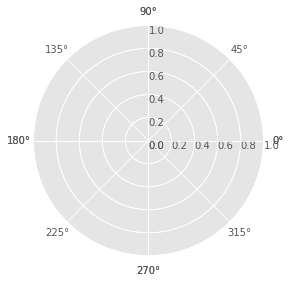

In [ ]:
def test_polar_alignment():
    '''
    Test that changing the vertical/horizontal alignment of a polar graph
    works as expected '''
    ranges = [(0, 5), (0, 5)]

    angles = np.arange(0, 360, 90)

    levels = 5

    fig = plt.figure()

    figureSize = [0.1, 0.1, 0.8, 0.8]

    horizontal = fig.add_axes(figureSize, polar=True, label='horizontal')
    vertical = fig.add_axes(figureSize, polar=True, label='vertical')

    axes = [horizontal, vertical]

    horizontal.set_thetagrids(angles)

    vertical.patch.set_visible(False)

    for i in range(2):
        grid = np.linspace(*ranges[i], num=levels)
        gridValues = [0, 0.2, 0.4, 0.6, 0.8, 1]
        axes[i].set_rgrids(gridValues, angle=angles[i],
                           horizontalalignment='left',
                           verticalalignment='top') 

test_polar_alignment()

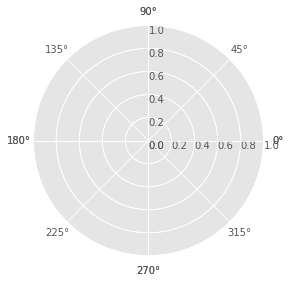

In [ ]:
test_polar_alignment()

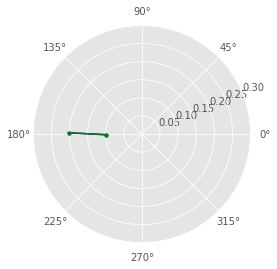

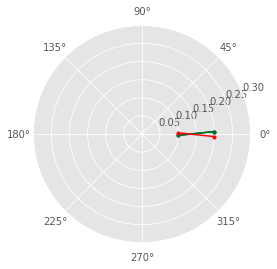

In [ ]:
def test_polar_wrap():
    fig = plt.figure()
    plt.subplot(111, polar=True)
    plt.polar(np.deg2rad([179, -179]), [0.2, 0.1], "b.-")
    plt.polar(np.deg2rad([179,  181]), [0.2, 0.1], "g.-")
    plt.rgrids([0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    assert len(fig.axes) == 1, 'More than one polar axes created.'

    fig = plt.figure()
    plt.subplot(111, polar=True)
    plt.polar(np.deg2rad([2, -2]), [0.2, 0.1], "b.-")
    plt.polar(np.deg2rad([2, 358]), [0.2, 0.1], "g.-")
    plt.polar(np.deg2rad([358, 2]), [0.2, 0.1], "r.-")
    plt.rgrids([0.05, 0.1, 0.15, 0.2, 0.25, 0.3]) 

test_polar_wrap()

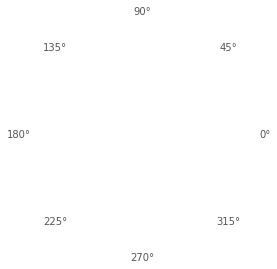

In [ ]:
def test_polar_gridlines():
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    # make all major grid lines lighter, only x grid lines set in 2.1.0
    ax.grid(alpha=0.2)

    # hide y tick labels, no effect in 2.1.0
    plt.setp(ax.yaxis.get_ticklabels(), visible=False)

    fig.canvas.draw()

    assert ax.xaxis.majorTicks[0].gridline.get_alpha() == .2
    assert ax.yaxis.majorTicks[0].gridline.get_alpha() == .2 
    ax.set_frame_on(False)
    #ax.axis('off')

test_polar_gridlines()

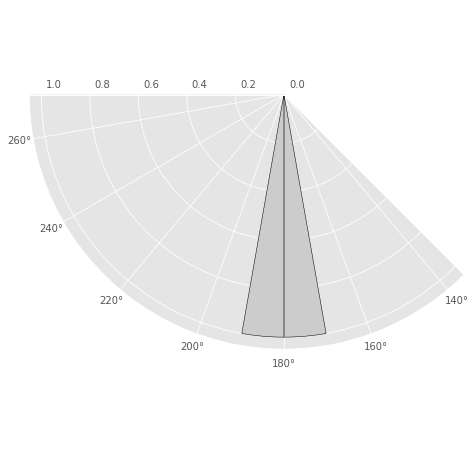

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

degrees = r_a
radians = theta_a

bin_size = 10
a , b=np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='polar')
ax.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, color='.8', edgecolor='k')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_thetamin(270)  #сектор
ax.set_thetamax(135)
plt.show()

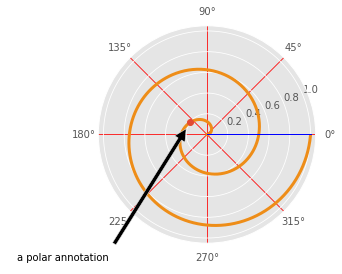

In [ ]:
def test_polar_annotations():
    # you can specify the xypoint and the xytext in different
    # positions and coordinate systems, and optionally turn on a
    # connecting line and mark the point with a marker.  Annotations
    # work on polar axes too.  In the example below, the xy point is
    # in native coordinates (xycoords defaults to 'data').  For a
    # polar axes, this is in (theta, radius) space.  The text in this
    # example is placed in the fractional figure coordinate system.
    # Text keyword args like horizontal and vertical alignment are
    # respected

    # Setup some data
    r = np.arange(0.0, 1.0, 0.001)
    theta = 2.0 * 2.0 * np.pi * r

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    line, = ax.plot(theta, r, color='#ee8d18', lw=3)
    line, = ax.plot((0, 0), (0, 1), color="#0000ff", lw=1)

    ind = 200 # index of point
    thisr, thistheta = r[ind], theta[ind]
    ax.plot([thistheta], [thisr], 'o')
    ax.annotate('a polar annotation',
                xy=(thistheta, thisr),  # theta, radius
                xytext=(0.05, 0.05),    # fraction, fraction
                textcoords='figure fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left',
                verticalalignment='baseline',
                #clip_on=True,  # clip to the axes bounding box
                ) 
    ax.xaxis.grid(True,color='r',linestyle='-') 
test_polar_annotations()

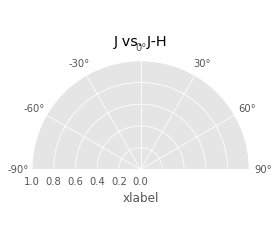

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar', xlim=(-90, 90))
ax.set_theta_direction(-1) # change direction to CCW
ax.set_thetamin(-90) # set the limits
ax.set_thetamax(90)
ax.set_theta_offset(.5*np.pi) # point the origin towards the top
ax.set_thetagrids(range(-90, 120, 30)) # set the gridlines
ax.set_title('J vs. J-H', pad=-50) # add title and relocate negative value lowers the location
ax.set_xlabel('xlabel')
ax.xaxis.set_label_coords(0.5, 0.15) # change the location of the xlabel to given x, y locations w.r.t. the entire figure

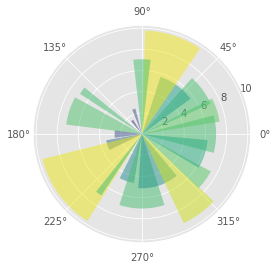

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute pie slices
N = 20
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(N)
width = np.pi / 4 * np.random.rand(N)
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)

plt.show()